# Required Libraries

In [16]:
%pip install torch pandas numpy matplotlib scikit-learn

769.01s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [17]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt

# Data Processing Classes and Functions


In [18]:
class IMDBDataset(Dataset):
    """PyTorch Dataset for IMDB movie reviews"""
    def __init__(self, reviews, labels, vocab, max_length=200):
        self.reviews = reviews
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length
        
    def __len__(self):
        return len(self.reviews)
        
    def __getitem__(self, idx):
        review = self.reviews[idx]
        sequence = self.text_to_sequence(review)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sequence, label
    
    def text_to_sequence(self, text):
        """Convert text to sequence of word indices"""
        words = text.split()
        sequence = [self.vocab.get(word, self.vocab['<unk>']) 
                   for word in words[:self.max_length]]
        
        # Pad sequence
        if len(sequence) < self.max_length:
            sequence += [self.vocab['<pad>']] * (self.max_length - len(sequence))
            
        return torch.tensor(sequence, dtype=torch.long)

def preprocess_text(text):
    """Clean and normalize text data"""
    text = text.lower()  # Convert to lowercase
    text = re.sub('<[^>]*>', '', text)  # Remove HTML tags
    text = re.sub('[^a-zA-Z\s]', '', text)  # Remove special characters
    return text.strip()

def build_vocabulary(texts, min_freq=5):
    """Build vocabulary from texts with minimum word frequency"""
    word_freq = {}
    for text in texts:
        for word in text.split():
            word_freq[word] = word_freq.get(word, 0) + 1
    
    # Create vocabulary with special tokens
    vocab = {'<pad>': 0, '<unk>': 1}
    for word, freq in word_freq.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    
    return vocab

def prepare_data(file_path, max_length=200):
    """Load and prepare IMDB dataset"""
    # Load dataset
    df = pd.read_csv(file_path)
    
    # Preprocess reviews
    reviews = df['review'].apply(preprocess_text).values
    labels = (df['sentiment'] == 'positive').astype(int).values
    
    # Build vocabulary
    vocab = build_vocabulary(reviews)
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        reviews, labels, test_size=0.2, random_state=42
    )
    
    # Create datasets
    train_dataset = IMDBDataset(X_train, y_train, vocab, max_length)
    val_dataset = IMDBDataset(X_val, y_val, vocab, max_length)
    
    return train_dataset, val_dataset, vocab

def create_dataloaders(train_dataset, val_dataset, batch_size=32):
    """Create DataLoader objects for training and validation"""
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )
    
    return train_loader, val_loader

# Loading the Dataset

In [19]:
# Prepare datasets
train_dataset, val_dataset, vocab = prepare_data('data/IMDB-Datasetfull.csv')

# Create dataloaders
train_loader, val_loader = create_dataloaders(train_dataset, val_dataset)

print(f"Vocabulary size: {len(vocab)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Vocabulary size: 4034
Training samples: 798
Validation samples: 200


# Understanding Sequential Data and RNNs


In [20]:
def show_example_reviews(train_dataset, n=2):
    indices = np.random.randint(0, len(train_dataset), n)
    for idx in indices:
        sequence, label = train_dataset[idx]
        sentiment = "Positive" if label.item() == 1 else "Negative"
        print(f"Review (Sentiment: {sentiment}):")
        print(f"{' '.join([list(vocab.keys())[i] for i in sequence if i not in [0, 1]])}\n")

show_example_reviews(train_dataset)

Review (Sentiment: Negative):
an american werewolf in london had some funny parts but this one isnt so good the computer are just awful the perspective is all off its like seeing them through a the writers step on the throat of many of their gags american boy says to girl is there a around here instead of just leaving it at that they have to have the girl sigh and this is paris

Review (Sentiment: Negative):
i saw this movie when i was about when it came out i recall the scene was the big eating men from right out of the air the horror the a young kid going to these cheesy b films on saturday i still was tired of the formula for these monster type movies that usually included the hero a beautiful woman who might be the daughter of a professor and a happy when the monster died in the end i didnt care much for the romantic angle as a year old and the predictable plots i love them now for the unintentional about a year or so later i saw psycho when it came out and i loved that the star wa

# Traditional Neural Networks vs. RNNs


In [21]:
# Traditional feedforward network
class SimpleFFN(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.fc = nn.Linear(hidden_size * 200, output_size)  # 200 is max_length
        
    def forward(self, x):
        # x shape: [batch_size, sequence_length]
        embedded = self.embedding(x)  # [batch_size, sequence_length, hidden_size]
        # Need to flatten because FFN can't handle sequences
        flattened = embedded.view(embedded.shape[0], -1)
        return self.fc(flattened)

# Basic RNN
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # x shape: [batch_size, sequence_length]
        embedded = self.embedding(x)  # [batch_size, sequence_length, embedding_dim]
        output, hidden = self.rnn(embedded)  # Process the sequence
        return self.fc(hidden.squeeze(0))

In [22]:
def manual_rnn_step(x_t, h_prev, W_xh, W_hh, b_h):
    """Compute one step of RNN manually"""
    # x_t: input at time t
    # h_prev: previous hidden state
    # W_xh: input-to-hidden weights
    # W_hh: hidden-to-hidden weights
    # b_h: bias
    
    # Combine input and hidden state calculations
    combined = torch.matmul(x_t, W_xh) + torch.matmul(h_prev, W_hh) + b_h
    
    # Apply tanh activation
    h_t = torch.tanh(combined)
    
    return h_t

# Example usage
batch_size = 2
input_size = 10
hidden_size = 20

# Random inputs and weights
x_t = torch.randn(batch_size, input_size)
h_prev = torch.randn(batch_size, hidden_size)
W_xh = torch.randn(input_size, hidden_size)
W_hh = torch.randn(hidden_size, hidden_size)
b_h = torch.randn(hidden_size)

# Compute one RNN step
h_t = manual_rnn_step(x_t, h_prev, W_xh, W_hh, b_h)
print("Hidden state shape:", h_t.shape)

Hidden state shape: torch.Size([2, 20])


# The Vanishing Gradient Problem


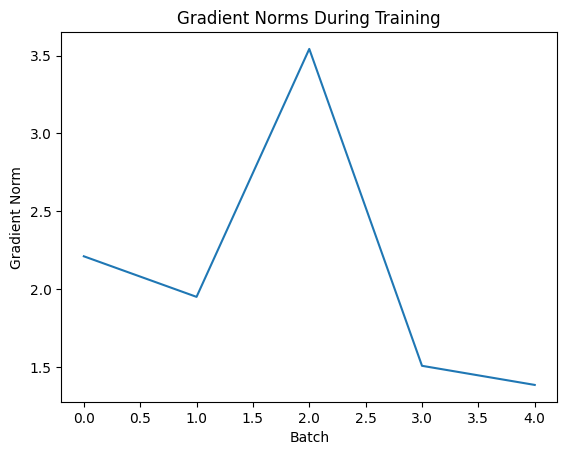

In [23]:
def train_simple_rnn():
    """Train a simple RNN and monitor gradients"""
    model = SimpleRNN(len(vocab), embedding_dim=100, hidden_size=256, output_size=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    gradient_norms = []
    
    # Training loop
    for batch_idx, (text, labels) in enumerate(train_loader):
        if batch_idx >= 5:  # Just look at first few batches
            break
            
        optimizer.zero_grad()
        output = model(text)
        loss = criterion(output, labels)
        loss.backward()
        
        # Record gradient norms
        grad_norm = 0
        for param in model.rnn.parameters():
            if param.grad is not None:
                grad_norm += param.grad.norm().item()
        gradient_norms.append(grad_norm)
        
        optimizer.step()
    
    return gradient_norms

gradient_norms = train_simple_rnn()
plt.plot(gradient_norms)
plt.title('Gradient Norms During Training')
plt.xlabel('Batch')
plt.ylabel('Gradient Norm')
plt.show()

# Long Short-Term Memory (LSTM) Networks

In [24]:
class LSTMSentimentAnalyzer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5):
        super().__init__()
        
        # Embedding layer converts word indices to dense vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer processes the sequence
        self.lstm = nn.LSTM(embedding_dim, 
                          hidden_dim, 
                          num_layers=n_layers, 
                          dropout=dropout if n_layers > 1 else 0,
                          batch_first=True)
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Linear layer for final prediction
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        # text shape: [batch size, sequence length]
        
        # Embed the text
        embedded = self.embedding(text)
        # embedded shape: [batch size, sequence length, embedding dim]
        
        # Pass through LSTM
        output, (hidden, cell) = self.lstm(embedded)
        # hidden shape: [n layers * n directions, batch size, hidden dim]
        
        # Apply dropout to hidden state
        hidden = self.dropout(hidden[-1,:,:])
        # hidden shape: [batch size, hidden dim]
        
        # Pass through linear layer
        return self.fc(hidden)

In [25]:
def train_lstm_model(train_loader, val_loader, vocab_size):
    # Model parameters
    EMBEDDING_DIM = 100
    HIDDEN_DIM = 256
    OUTPUT_DIM = 2
    N_LAYERS = 2
    DROPOUT = 0.5
    
    # Initialize model, criterion, and optimizer
    model = LSTMSentimentAnalyzer(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    # Training history
    train_losses = []
    val_accuracies = []
    
    # Training loop
    for epoch in range(5):  # 5 epochs for demonstration
        # Training phase
        model.train()
        epoch_loss = 0
        for batch_idx, (text, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            predictions = model(text)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            # Print progress every 100 batches
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
        
        avg_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)
        
        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for text, labels in val_loader:
                predictions = model(text)
                _, predicted = torch.max(predictions, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        val_accuracies.append(accuracy)
        print(f'Epoch: {epoch+1}, Loss: {avg_epoch_loss:.4f}, Accuracy: {accuracy:.2f}%\n')
    
    return model, train_losses, val_accuracies

Epoch: 1, Batch: 0, Loss: 0.6955
Epoch: 1, Loss: 0.6954, Accuracy: 49.50%

Epoch: 2, Batch: 0, Loss: 0.6681
Epoch: 2, Loss: 0.6881, Accuracy: 47.50%

Epoch: 3, Batch: 0, Loss: 0.6994
Epoch: 3, Loss: 0.6815, Accuracy: 46.00%

Epoch: 4, Batch: 0, Loss: 0.6434
Epoch: 4, Loss: 0.6381, Accuracy: 47.50%

Epoch: 5, Batch: 0, Loss: 0.5793
Epoch: 5, Loss: 0.5841, Accuracy: 46.00%



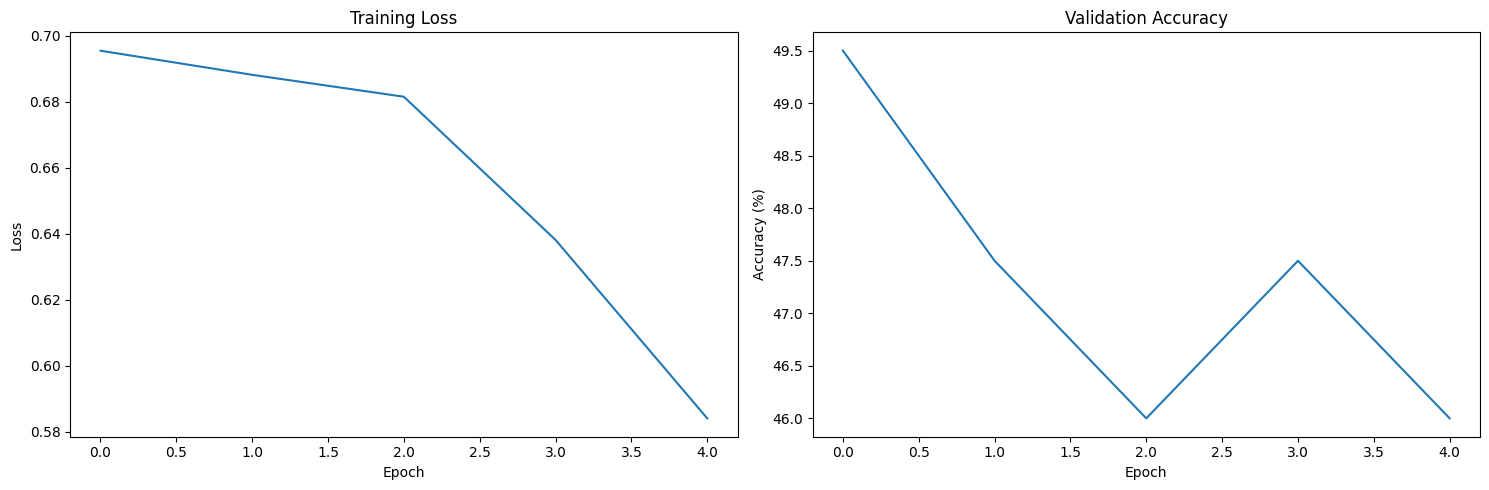

In [26]:
def plot_training_progress(train_losses, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training loss
    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    
    # Plot validation accuracy
    ax2.plot(val_accuracies)
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    
    plt.tight_layout()
    plt.show()

# Train the model and visualize results
model, train_losses, val_accuracies = train_lstm_model(train_loader, val_loader, len(vocab))
plot_training_progress(train_losses, val_accuracies)

# GRU 

In [27]:
class GRUSentimentAnalyzer(nn.Module):
	    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5):
	        super().__init__()
	        
	        # Embedding layer
	        self.embedding = nn.Embedding(vocab_size, embedding_dim)
	        
	        # GRU layer
	        self.gru = nn.GRU(embedding_dim,
	                         hidden_dim,
	                         num_layers=n_layers,
	                         dropout=dropout if n_layers > 1 else 0,
	                         batch_first=True)
	        
	        # Dropout layer
	        self.dropout = nn.Dropout(dropout)
	        
	        # Linear layer
	        self.fc = nn.Linear(hidden_dim, output_dim)
	        
	    def forward(self, text):
	        # Embed text
	        embedded = self.embedding(text)
	        
	        # Process through GRU
	        output, hidden = self.gru(embedded)
	        
	        # Apply dropout to final hidden state
	        hidden = self.dropout(hidden[-1,:,:])
	        
	        # Final prediction
	        return self.fc(hidden)


# Comparing LSTM and GRU Performance

In [28]:
def train_epoch(model, train_loader, criterion, optimizer):
    """Train model for one epoch and return average loss"""
    model.train()
    total_loss = 0
    
    for texts, labels in train_loader:
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def evaluate_model(model, val_loader):
    """Evaluate model and return accuracy"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for texts, labels in val_loader:
            outputs = model(texts)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100 * correct / total

def update_history(history, lstm_loss, gru_loss, lstm_acc, gru_acc, lstm_time, gru_time):
    """Update training history dictionary with new metrics"""
    history['lstm_loss'].append(lstm_loss)
    history['gru_loss'].append(gru_loss)
    history['lstm_acc'].append(lstm_acc)
    history['gru_acc'].append(gru_acc)
    history['lstm_time'].append(lstm_time)
    history['gru_time'].append(gru_time)

In [29]:
import time 

def compare_models():
    """Compare LSTM and GRU performance and training time"""
    # Model parameters
    EMBEDDING_DIM = 100
    HIDDEN_DIM = 256
    OUTPUT_DIM = 2
    N_LAYERS = 2
    DROPOUT = 0.5
    
    # Initialize models with identical parameters
    lstm_model = LSTMSentimentAnalyzer(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, 
                                        OUTPUT_DIM, N_LAYERS, DROPOUT)
    gru_model = GRUSentimentAnalyzer(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, 
                                    OUTPUT_DIM, N_LAYERS, DROPOUT)
    
    # Training setup
    criterion = nn.CrossEntropyLoss()
    lstm_optimizer = torch.optim.Adam(lstm_model.parameters())
    gru_optimizer = torch.optim.Adam(gru_model.parameters())
    
    # Track performance metrics
    history = {
        'lstm_loss': [], 'gru_loss': [],
        'lstm_acc': [], 'gru_acc': [],
        'lstm_time': [], 'gru_time': []
    }
    
    # Training loop
    for epoch in range(3):
        print(f'Epoch {epoch+1}:')
        
        # Train and time each model
        start_time = time.time()
        lstm_loss = train_epoch(lstm_model, train_loader, criterion, lstm_optimizer)
        lstm_time = time.time() - start_time
        lstm_acc = evaluate_model(lstm_model, val_loader)
        
        start_time = time.time()
        gru_loss = train_epoch(gru_model, train_loader, criterion, gru_optimizer)
        gru_time = time.time() - start_time
        gru_acc = evaluate_model(gru_model, val_loader)
        
        # Record metrics
        update_history(history, lstm_loss, gru_loss, lstm_acc, gru_acc, 
                        lstm_time, gru_time)
        
        print(f'LSTM - Loss: {lstm_loss:.4f}, Accuracy: {lstm_acc:.2f}%, Time: {lstm_time:.2f}s')
        print(f'GRU  - Loss: {gru_loss:.4f}, Accuracy: {gru_acc:.2f}%, Time: {gru_time:.2f}s\n')
    
    return history


In [30]:
def visualize_comparison(history):
    """Create comprehensive performance comparison visualizations"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Training Loss Comparison
    ax1.plot(history['lstm_loss'], label='LSTM')
    ax1.plot(history['gru_loss'], label='GRU')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Validation Accuracy Comparison
    ax2.plot(history['lstm_acc'], label='LSTM')
    ax2.plot(history['gru_acc'], label='GRU')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    
    # Training Time Comparison
    ax3.bar(['LSTM', 'GRU'], 
            [np.mean(history['lstm_time']), np.mean(history['gru_time'])],
            yerr=[np.std(history['lstm_time']), np.std(history['gru_time'])])
    ax3.set_title('Average Training Time per Epoch')
    ax3.set_ylabel('Time (seconds)')
    
    # Cumulative Time
    cumulative_lstm = np.cumsum(history['lstm_time'])
    cumulative_gru = np.cumsum(history['gru_time'])
    ax4.plot(cumulative_lstm, label='LSTM')
    ax4.plot(cumulative_gru, label='GRU')
    ax4.set_title('Cumulative Training Time')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Time (seconds)')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()


Epoch 1:
LSTM - Loss: 0.7020, Accuracy: 51.00%, Time: 3.77s
GRU  - Loss: 0.7066, Accuracy: 49.50%, Time: 3.26s

Epoch 2:
LSTM - Loss: 0.6883, Accuracy: 51.50%, Time: 3.65s
GRU  - Loss: 0.6948, Accuracy: 51.50%, Time: 3.50s

Epoch 3:
LSTM - Loss: 0.6754, Accuracy: 52.50%, Time: 3.99s
GRU  - Loss: 0.6848, Accuracy: 50.50%, Time: 3.33s



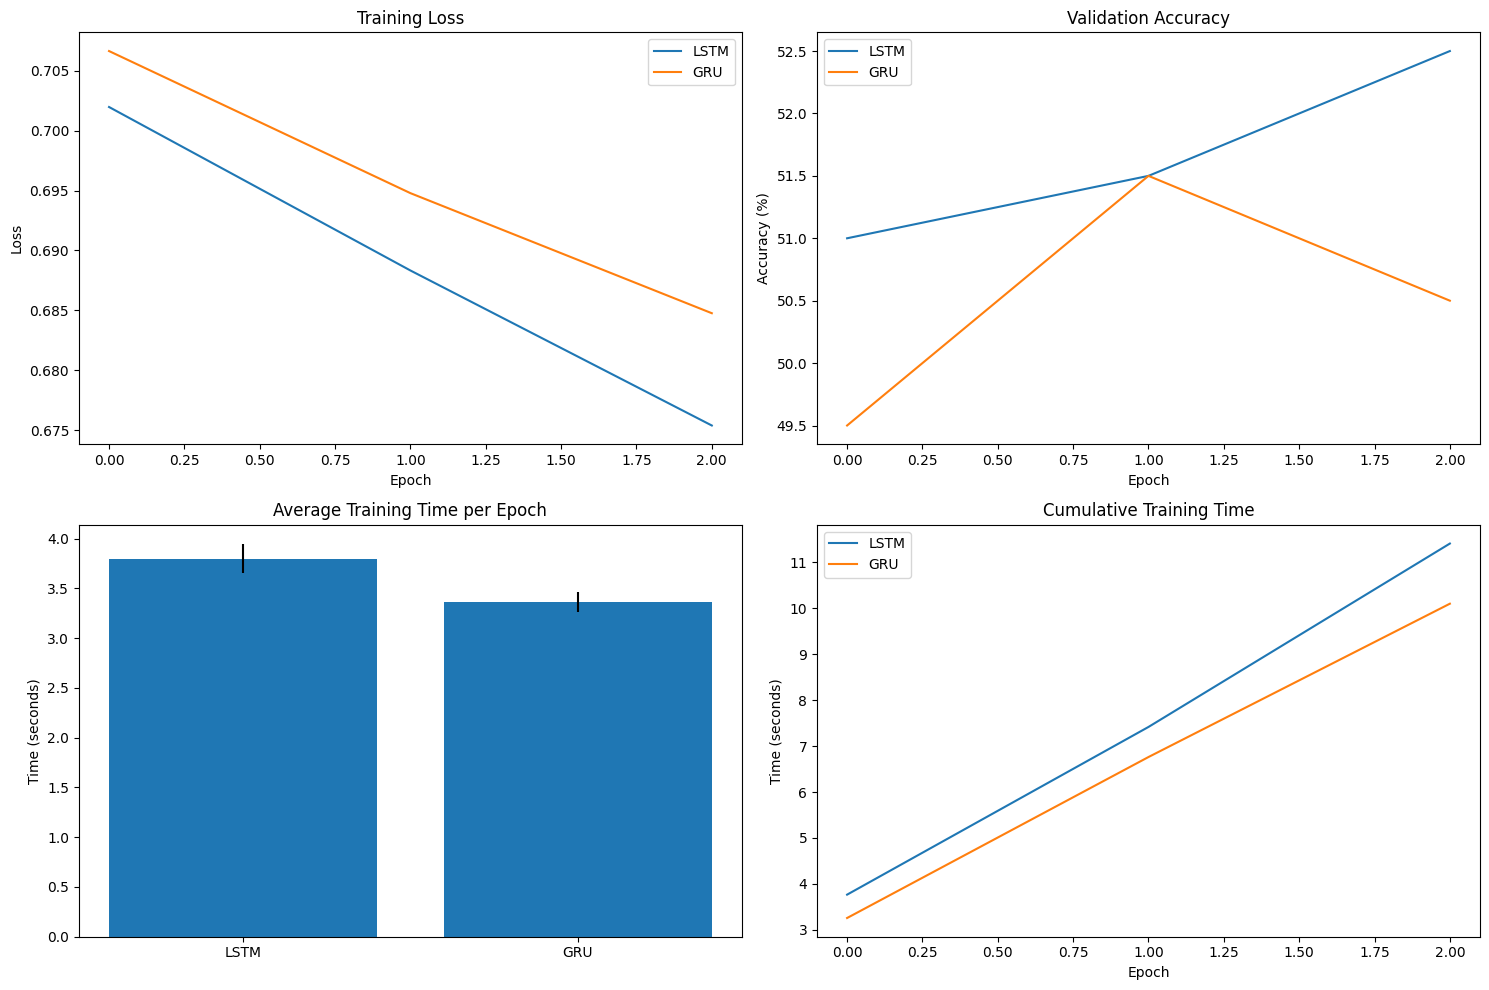

In [31]:
history = compare_models()
visualize_comparison(history) 